In [67]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

### Getting Key Points using MP holistic

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [5]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [30]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = mediapipe_detection(frame,holistic)
        #print(results)
        
        #draw_landmarks(image,results)
        draw_styled_landmarks(image,results)
         
        cv2.imshow("OpenCV Feed",image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [31]:
draw_styled_landmarks(frame, results)

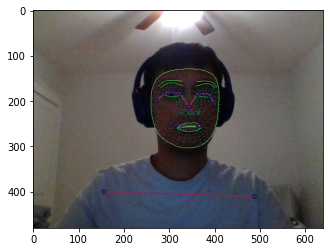

In [32]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

#### Extract Keypoint values from our MP Holictic Landmark features

In [33]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test) 

In [34]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [35]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

#### Setup folders for data collection

In [53]:
DATA_PATH = os.path.join('data') 

actions = np.array(['hello', 'thanks', 'iloveyou','volup','voldown'])

no_sequences = 30

sequence_length = 30

start_folder = 30

In [54]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

#### Collecting data for training and testing

In [55]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, holistic)
                draw_styled_landmarks(image, results)

                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(1000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

#### DataSplitting into training and testing

In [59]:
label_map = {label:num for num, label in enumerate(actions)}
print(label_map)

{'hello': 0, 'thanks': 1, 'iloveyou': 2, 'volup': 3, 'voldown': 4}


In [60]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [62]:
x = np.array(sequences)

In [63]:
y = to_categorical(labels).astype(int)

In [64]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.05)

In [65]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((142, 30, 1662), (8, 30, 1662), (142, 5), (8, 5))

#### Train the LSTM Model

In [110]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [111]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [112]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 30, 64)            442112    
_________________________________________________________________
lstm_47 (LSTM)               (None, 30, 128)           98816     
_________________________________________________________________
lstm_48 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 165       
Total params: 596,741
Trainable params: 596,741
Non-trainable params: 0
_______________________________________________

In [114]:
model.fit(x_train, y_train, epochs=2000)

Epoch 1/2000
5/5 [==============================] - 0s 88ms/step - loss: 74.5346 - categorical_accuracy: 0.2183
Epoch 2/2000
5/5 [==============================] - 0s 85ms/step - loss: 53.5176 - categorical_accuracy: 0.2465
Epoch 3/2000
5/5 [==============================] - 0s 89ms/step - loss: 43.8503 - categorical_accuracy: 0.1831
Epoch 4/2000
5/5 [==============================] - 0s 87ms/step - loss: 59.8131 - categorical_accuracy: 0.1901
Epoch 5/2000
5/5 [==============================] - 0s 87ms/step - loss: 88.8624 - categorical_accuracy: 0.2676
Epoch 6/2000
5/5 [==============================] - 0s 87ms/step - loss: 92.7922 - categorical_accuracy: 0.2183
Epoch 7/2000
5/5 [==============================] - 0s 91ms/step - loss: 80.7987 - categorical_accuracy: 0.1901
Epoch 8/2000
5/5 [==============================] - 1s 99ms/step - loss: 36.1080 - categorical_accuracy: 0.2958
Epoch 9/2000
5/5 [==============================] - 0s 97ms/step - loss: 59.5154 - categorical_accuracy:

5/5 [==============================] - 0s 85ms/step - loss: 17.5337 - categorical_accuracy: 0.2958
Epoch 74/2000
5/5 [==============================] - 0s 84ms/step - loss: 12.6246 - categorical_accuracy: 0.2606
Epoch 75/2000
5/5 [==============================] - 0s 83ms/step - loss: 10.8489 - categorical_accuracy: 0.2887
Epoch 76/2000
5/5 [==============================] - 0s 85ms/step - loss: 18.1612 - categorical_accuracy: 0.2042
Epoch 77/2000
5/5 [==============================] - 0s 83ms/step - loss: 15.6473 - categorical_accuracy: 0.2042
Epoch 78/2000
5/5 [==============================] - 0s 83ms/step - loss: 11.8549 - categorical_accuracy: 0.2465
Epoch 79/2000
5/5 [==============================] - 0s 83ms/step - loss: 16.3598 - categorical_accuracy: 0.2535
Epoch 80/2000
5/5 [==============================] - 0s 84ms/step - loss: 14.6517 - categorical_accuracy: 0.2394
Epoch 81/2000
5/5 [==============================] - 0s 86ms/step - loss: 18.1964 - categorical_accuracy: 0.23

5/5 [==============================] - 0s 85ms/step - loss: 10.3965 - categorical_accuracy: 0.2606
Epoch 146/2000
5/5 [==============================] - 0s 83ms/step - loss: 13.6089 - categorical_accuracy: 0.1690
Epoch 147/2000
5/5 [==============================] - 0s 84ms/step - loss: 13.5716 - categorical_accuracy: 0.1972
Epoch 148/2000
5/5 [==============================] - 0s 84ms/step - loss: 14.1466 - categorical_accuracy: 0.2324
Epoch 149/2000
5/5 [==============================] - 0s 85ms/step - loss: 27.8634 - categorical_accuracy: 0.1972
Epoch 150/2000
5/5 [==============================] - 0s 84ms/step - loss: 31.5097 - categorical_accuracy: 0.2042
Epoch 151/2000
5/5 [==============================] - 0s 83ms/step - loss: 30.1554 - categorical_accuracy: 0.2042
Epoch 152/2000
5/5 [==============================] - 0s 84ms/step - loss: 31.7430 - categorical_accuracy: 0.1620
Epoch 153/2000
5/5 [==============================] - 0s 85ms/step - loss: 30.9662 - categorical_accura

5/5 [==============================] - 1s 102ms/step - loss: 15.4271 - categorical_accuracy: 0.2887
Epoch 217/2000
5/5 [==============================] - 0s 93ms/step - loss: 16.7753 - categorical_accuracy: 0.2958
Epoch 218/2000
5/5 [==============================] - 0s 92ms/step - loss: 15.1610 - categorical_accuracy: 0.3099
Epoch 219/2000
5/5 [==============================] - 0s 93ms/step - loss: 15.6778 - categorical_accuracy: 0.3028
Epoch 220/2000
5/5 [==============================] - 0s 92ms/step - loss: 12.9651 - categorical_accuracy: 0.2887
Epoch 221/2000
5/5 [==============================] - 0s 89ms/step - loss: 16.1572 - categorical_accuracy: 0.2324
Epoch 222/2000
5/5 [==============================] - 0s 92ms/step - loss: 19.8776 - categorical_accuracy: 0.2676
Epoch 223/2000
5/5 [==============================] - 0s 92ms/step - loss: 14.3913 - categorical_accuracy: 0.3239
Epoch 224/2000
5/5 [==============================] - 0s 89ms/step - loss: 13.8729 - categorical_accur

5/5 [==============================] - 1s 121ms/step - loss: 18.2622 - categorical_accuracy: 0.2183
Epoch 288/2000
5/5 [==============================] - 1s 105ms/step - loss: 13.3244 - categorical_accuracy: 0.2254 0s - loss: 13.3244 - categorical_accuracy: 0.225
Epoch 289/2000
5/5 [==============================] - 1s 123ms/step - loss: 11.6936 - categorical_accuracy: 0.1549
Epoch 290/2000
5/5 [==============================] - 1s 99ms/step - loss: 11.7921 - categorical_accuracy: 0.1972
Epoch 291/2000
5/5 [==============================] - 1s 98ms/step - loss: 10.2681 - categorical_accuracy: 0.2324
Epoch 292/2000
5/5 [==============================] - 0s 98ms/step - loss: 7.3129 - categorical_accuracy: 0.2183
Epoch 293/2000
5/5 [==============================] - 1s 100ms/step - loss: 8.2288 - categorical_accuracy: 0.2254
Epoch 294/2000
5/5 [==============================] - 0s 98ms/step - loss: 13.2697 - categorical_accuracy: 0.2113
Epoch 295/2000
5/5 [==============================] 

5/5 [==============================] - 0s 99ms/step - loss: 7.5538 - categorical_accuracy: 0.2606
Epoch 359/2000
5/5 [==============================] - 1s 99ms/step - loss: 6.1767 - categorical_accuracy: 0.2676
Epoch 360/2000
5/5 [==============================] - 1s 105ms/step - loss: 6.3201 - categorical_accuracy: 0.2394
Epoch 361/2000
5/5 [==============================] - 0s 95ms/step - loss: 5.8130 - categorical_accuracy: 0.2746
Epoch 362/2000
5/5 [==============================] - 1s 100ms/step - loss: 7.8119 - categorical_accuracy: 0.1972
Epoch 363/2000
5/5 [==============================] - 0s 100ms/step - loss: 8.6089 - categorical_accuracy: 0.1972
Epoch 364/2000
5/5 [==============================] - 0s 95ms/step - loss: 7.8043 - categorical_accuracy: 0.2324
Epoch 365/2000
5/5 [==============================] - 1s 127ms/step - loss: 6.0966 - categorical_accuracy: 0.2324
Epoch 366/2000
5/5 [==============================] - 1s 106ms/step - loss: 4.8811 - categorical_accuracy: 

5/5 [==============================] - 1s 134ms/step - loss: 6.9237 - categorical_accuracy: 0.2746
Epoch 431/2000
5/5 [==============================] - 1s 113ms/step - loss: 5.3440 - categorical_accuracy: 0.2535
Epoch 432/2000
5/5 [==============================] - 1s 105ms/step - loss: 4.9268 - categorical_accuracy: 0.2817
Epoch 433/2000
5/5 [==============================] - 1s 126ms/step - loss: 3.0268 - categorical_accuracy: 0.4507
Epoch 434/2000
5/5 [==============================] - 1s 104ms/step - loss: 3.1312 - categorical_accuracy: 0.3944
Epoch 435/2000
5/5 [==============================] - 1s 103ms/step - loss: 3.6103 - categorical_accuracy: 0.4085
Epoch 436/2000
5/5 [==============================] - 0s 92ms/step - loss: 3.2605 - categorical_accuracy: 0.4225
Epoch 437/2000
5/5 [==============================] - 0s 92ms/step - loss: 3.5890 - categorical_accuracy: 0.3873
Epoch 438/2000
5/5 [==============================] - 0s 91ms/step - loss: 3.6305 - categorical_accuracy:

5/5 [==============================] - 0s 91ms/step - loss: 6.6350 - categorical_accuracy: 0.2254
Epoch 503/2000
5/5 [==============================] - 0s 92ms/step - loss: 4.8395 - categorical_accuracy: 0.3521
Epoch 504/2000
5/5 [==============================] - 0s 90ms/step - loss: 4.2592 - categorical_accuracy: 0.2465
Epoch 505/2000
5/5 [==============================] - 0s 92ms/step - loss: 4.7881 - categorical_accuracy: 0.3239
Epoch 506/2000
5/5 [==============================] - 0s 89ms/step - loss: 4.7495 - categorical_accuracy: 0.2324
Epoch 507/2000
5/5 [==============================] - 0s 96ms/step - loss: 2.9667 - categorical_accuracy: 0.3592 0s - loss: 2.7034 - categorical_accuracy
Epoch 508/2000
5/5 [==============================] - 0s 92ms/step - loss: 2.7028 - categorical_accuracy: 0.4014
Epoch 509/2000
5/5 [==============================] - 0s 91ms/step - loss: 2.9112 - categorical_accuracy: 0.3169
Epoch 510/2000
5/5 [==============================] - 0s 94ms/step - l

5/5 [==============================] - 0s 92ms/step - loss: 1.7554 - categorical_accuracy: 0.3310
Epoch 574/2000
5/5 [==============================] - 0s 91ms/step - loss: 1.8325 - categorical_accuracy: 0.3380
Epoch 575/2000
5/5 [==============================] - 0s 91ms/step - loss: 1.7509 - categorical_accuracy: 0.4014
Epoch 576/2000
5/5 [==============================] - 0s 91ms/step - loss: 1.6897 - categorical_accuracy: 0.3944
Epoch 577/2000
5/5 [==============================] - 0s 91ms/step - loss: 1.6574 - categorical_accuracy: 0.3451
Epoch 578/2000
5/5 [==============================] - 0s 92ms/step - loss: 2.7418 - categorical_accuracy: 0.3028
Epoch 579/2000
5/5 [==============================] - 0s 91ms/step - loss: 2.3227 - categorical_accuracy: 0.3099
Epoch 580/2000
5/5 [==============================] - 0s 93ms/step - loss: 2.2026 - categorical_accuracy: 0.3451
Epoch 581/2000
5/5 [==============================] - 0s 92ms/step - loss: 2.0026 - categorical_accuracy: 0.295

5/5 [==============================] - 0s 97ms/step - loss: 1.4272 - categorical_accuracy: 0.4859
Epoch 646/2000
5/5 [==============================] - 0s 92ms/step - loss: 1.6156 - categorical_accuracy: 0.4366
Epoch 647/2000
5/5 [==============================] - 0s 92ms/step - loss: 1.9953 - categorical_accuracy: 0.3310
Epoch 648/2000
5/5 [==============================] - 0s 91ms/step - loss: 2.0611 - categorical_accuracy: 0.3310
Epoch 649/2000
5/5 [==============================] - 0s 92ms/step - loss: 2.0963 - categorical_accuracy: 0.3873
Epoch 650/2000
5/5 [==============================] - 0s 91ms/step - loss: 2.0447 - categorical_accuracy: 0.3592
Epoch 651/2000
5/5 [==============================] - 0s 91ms/step - loss: 1.7586 - categorical_accuracy: 0.4014
Epoch 652/2000
5/5 [==============================] - 0s 91ms/step - loss: 1.7822 - categorical_accuracy: 0.3873
Epoch 653/2000
5/5 [==============================] - 0s 99ms/step - loss: 1.9693 - categorical_accuracy: 0.380

5/5 [==============================] - 0s 94ms/step - loss: 1.6704 - categorical_accuracy: 0.3944
Epoch 718/2000
5/5 [==============================] - 0s 90ms/step - loss: 2.4153 - categorical_accuracy: 0.2887
Epoch 719/2000
5/5 [==============================] - 0s 92ms/step - loss: 1.6302 - categorical_accuracy: 0.4085
Epoch 720/2000
5/5 [==============================] - 0s 90ms/step - loss: 1.4963 - categorical_accuracy: 0.5070
Epoch 721/2000
5/5 [==============================] - 0s 92ms/step - loss: 1.4855 - categorical_accuracy: 0.4225
Epoch 722/2000
5/5 [==============================] - 0s 91ms/step - loss: 1.7521 - categorical_accuracy: 0.4085 0s - loss: 1.7581 - categorical_accuracy: 0.
Epoch 723/2000
5/5 [==============================] - 0s 93ms/step - loss: 1.4629 - categorical_accuracy: 0.4366
Epoch 724/2000
5/5 [==============================] - 0s 92ms/step - loss: 2.4599 - categorical_accuracy: 0.4085
Epoch 725/2000
5/5 [==============================] - 0s 92ms/step

5/5 [==============================] - 0s 91ms/step - loss: 10.3876 - categorical_accuracy: 0.3028
Epoch 790/2000
5/5 [==============================] - 0s 91ms/step - loss: 10.7297 - categorical_accuracy: 0.2887
Epoch 791/2000
5/5 [==============================] - 0s 90ms/step - loss: 9.5615 - categorical_accuracy: 0.2676
Epoch 792/2000
5/5 [==============================] - 0s 91ms/step - loss: 7.4625 - categorical_accuracy: 0.3310
Epoch 793/2000
5/5 [==============================] - 0s 92ms/step - loss: 6.2844 - categorical_accuracy: 0.2324
Epoch 794/2000
5/5 [==============================] - 0s 91ms/step - loss: 4.0629 - categorical_accuracy: 0.3380
Epoch 795/2000
5/5 [==============================] - 0s 91ms/step - loss: 5.1411 - categorical_accuracy: 0.2113
Epoch 796/2000
5/5 [==============================] - 0s 93ms/step - loss: 5.0477 - categorical_accuracy: 0.3028
Epoch 797/2000
5/5 [==============================] - 0s 91ms/step - loss: 4.3977 - categorical_accuracy: 0.2

5/5 [==============================] - 0s 93ms/step - loss: 2.3427 - categorical_accuracy: 0.3380
Epoch 862/2000
5/5 [==============================] - 0s 92ms/step - loss: 2.2946 - categorical_accuracy: 0.3803
Epoch 863/2000
5/5 [==============================] - 0s 92ms/step - loss: 2.9071 - categorical_accuracy: 0.2465
Epoch 864/2000
5/5 [==============================] - 0s 92ms/step - loss: 3.1031 - categorical_accuracy: 0.3310
Epoch 865/2000
5/5 [==============================] - 0s 92ms/step - loss: 4.0369 - categorical_accuracy: 0.3310
Epoch 866/2000
5/5 [==============================] - 0s 92ms/step - loss: 3.2600 - categorical_accuracy: 0.3803
Epoch 867/2000
5/5 [==============================] - 0s 92ms/step - loss: 2.9490 - categorical_accuracy: 0.3592
Epoch 868/2000
5/5 [==============================] - 0s 95ms/step - loss: 2.5067 - categorical_accuracy: 0.3099
Epoch 869/2000
5/5 [==============================] - 0s 91ms/step - loss: 2.1513 - categorical_accuracy: 0.380

5/5 [==============================] - 0s 96ms/step - loss: 2.6714 - categorical_accuracy: 0.2394
Epoch 934/2000
5/5 [==============================] - 0s 93ms/step - loss: 2.0951 - categorical_accuracy: 0.3732
Epoch 935/2000
5/5 [==============================] - 1s 100ms/step - loss: 2.3161 - categorical_accuracy: 0.2887
Epoch 936/2000
5/5 [==============================] - 0s 92ms/step - loss: 2.0170 - categorical_accuracy: 0.4014
Epoch 937/2000
5/5 [==============================] - 0s 91ms/step - loss: 1.7829 - categorical_accuracy: 0.3944
Epoch 938/2000
5/5 [==============================] - 0s 93ms/step - loss: 2.0267 - categorical_accuracy: 0.3803
Epoch 939/2000
5/5 [==============================] - 0s 93ms/step - loss: 2.9837 - categorical_accuracy: 0.3380
Epoch 940/2000
5/5 [==============================] - 0s 92ms/step - loss: 3.4944 - categorical_accuracy: 0.2113
Epoch 941/2000
5/5 [==============================] - 0s 90ms/step - loss: 3.4170 - categorical_accuracy: 0.32

5/5 [==============================] - 0s 92ms/step - loss: 1.3957 - categorical_accuracy: 0.5000
Epoch 1006/2000
5/5 [==============================] - 0s 91ms/step - loss: 1.2538 - categorical_accuracy: 0.4930
Epoch 1007/2000
5/5 [==============================] - 0s 91ms/step - loss: 1.5724 - categorical_accuracy: 0.4648
Epoch 1008/2000
5/5 [==============================] - 0s 92ms/step - loss: 1.2802 - categorical_accuracy: 0.5352
Epoch 1009/2000
5/5 [==============================] - 0s 91ms/step - loss: 1.6399 - categorical_accuracy: 0.4366
Epoch 1010/2000
5/5 [==============================] - 0s 92ms/step - loss: 1.4283 - categorical_accuracy: 0.5141
Epoch 1011/2000
5/5 [==============================] - 0s 91ms/step - loss: 1.4960 - categorical_accuracy: 0.5704
Epoch 1012/2000
5/5 [==============================] - 0s 96ms/step - loss: 2.1023 - categorical_accuracy: 0.3732
Epoch 1013/2000
5/5 [==============================] - 0s 93ms/step - loss: 1.7215 - categorical_accurac

5/5 [==============================] - 1s 106ms/step - loss: 1.8311 - categorical_accuracy: 0.3521
Epoch 1077/2000
5/5 [==============================] - 1s 112ms/step - loss: 1.8204 - categorical_accuracy: 0.3239
Epoch 1078/2000
5/5 [==============================] - 1s 106ms/step - loss: 1.4372 - categorical_accuracy: 0.4085
Epoch 1079/2000
5/5 [==============================] - 1s 109ms/step - loss: 1.4353 - categorical_accuracy: 0.4014
Epoch 1080/2000
5/5 [==============================] - 1s 126ms/step - loss: 1.3251 - categorical_accuracy: 0.4014
Epoch 1081/2000
5/5 [==============================] - 1s 98ms/step - loss: 1.2718 - categorical_accuracy: 0.4366
Epoch 1082/2000
5/5 [==============================] - 1s 102ms/step - loss: 1.1343 - categorical_accuracy: 0.5000
Epoch 1083/2000
5/5 [==============================] - 1s 102ms/step - loss: 1.1348 - categorical_accuracy: 0.5141
Epoch 1084/2000
5/5 [==============================] - 1s 114ms/step - loss: 1.1223 - categorical

5/5 [==============================] - 0s 92ms/step - loss: 1.1163 - categorical_accuracy: 0.5493
Epoch 1148/2000
5/5 [==============================] - 0s 92ms/step - loss: 1.1267 - categorical_accuracy: 0.5141
Epoch 1149/2000
5/5 [==============================] - 0s 92ms/step - loss: 1.0858 - categorical_accuracy: 0.5775 0s - loss: 1.1032 - categorical_accuracy: 0.
Epoch 1150/2000
5/5 [==============================] - 0s 96ms/step - loss: 1.1639 - categorical_accuracy: 0.5704
Epoch 1151/2000
5/5 [==============================] - 0s 91ms/step - loss: 1.1019 - categorical_accuracy: 0.4930
Epoch 1152/2000
5/5 [==============================] - 0s 93ms/step - loss: 1.1732 - categorical_accuracy: 0.5845
Epoch 1153/2000
5/5 [==============================] - 0s 91ms/step - loss: 1.0982 - categorical_accuracy: 0.5563
Epoch 1154/2000
5/5 [==============================] - 0s 92ms/step - loss: 1.1004 - categorical_accuracy: 0.5563
Epoch 1155/2000
5/5 [==============================] - 0s 9

5/5 [==============================] - 0s 93ms/step - loss: 1.2582 - categorical_accuracy: 0.4577
Epoch 1218/2000
5/5 [==============================] - 0s 91ms/step - loss: 1.0638 - categorical_accuracy: 0.5493
Epoch 1219/2000
5/5 [==============================] - 0s 91ms/step - loss: 1.1564 - categorical_accuracy: 0.5282
Epoch 1220/2000
5/5 [==============================] - 0s 90ms/step - loss: 1.2204 - categorical_accuracy: 0.4789
Epoch 1221/2000
5/5 [==============================] - 0s 93ms/step - loss: 1.1595 - categorical_accuracy: 0.5845
Epoch 1222/2000
5/5 [==============================] - 1s 101ms/step - loss: 1.2740 - categorical_accuracy: 0.4718
Epoch 1223/2000
5/5 [==============================] - 0s 91ms/step - loss: 1.2067 - categorical_accuracy: 0.5211
Epoch 1224/2000
5/5 [==============================] - 1s 123ms/step - loss: 1.3198 - categorical_accuracy: 0.4437
Epoch 1225/2000
5/5 [==============================] - 1s 118ms/step - loss: 1.2617 - categorical_accu

5/5 [==============================] - 1s 110ms/step - loss: 1.3232 - categorical_accuracy: 0.3803
Epoch 1288/2000
5/5 [==============================] - 1s 131ms/step - loss: 1.1847 - categorical_accuracy: 0.5423
Epoch 1289/2000
5/5 [==============================] - 1s 115ms/step - loss: 1.2734 - categorical_accuracy: 0.4648
Epoch 1290/2000
5/5 [==============================] - 1s 113ms/step - loss: 1.4001 - categorical_accuracy: 0.4225
Epoch 1291/2000
5/5 [==============================] - 1s 149ms/step - loss: 1.1916 - categorical_accuracy: 0.5423
Epoch 1292/2000
5/5 [==============================] - 1s 99ms/step - loss: 1.0856 - categorical_accuracy: 0.5704
Epoch 1293/2000
5/5 [==============================] - 0s 96ms/step - loss: 1.0462 - categorical_accuracy: 0.5775
Epoch 1294/2000
5/5 [==============================] - 1s 114ms/step - loss: 1.0582 - categorical_accuracy: 0.5000
Epoch 1295/2000
5/5 [==============================] - 1s 112ms/step - loss: 1.1515 - categorical_

5/5 [==============================] - 0s 94ms/step - loss: 1.0493 - categorical_accuracy: 0.5845
Epoch 1359/2000
5/5 [==============================] - 0s 95ms/step - loss: 0.9742 - categorical_accuracy: 0.6127
Epoch 1360/2000
5/5 [==============================] - 1s 101ms/step - loss: 0.9620 - categorical_accuracy: 0.6901
Epoch 1361/2000
5/5 [==============================] - 0s 99ms/step - loss: 1.1854 - categorical_accuracy: 0.5070
Epoch 1362/2000
5/5 [==============================] - 1s 105ms/step - loss: 1.0672 - categorical_accuracy: 0.5563
Epoch 1363/2000
5/5 [==============================] - 0s 97ms/step - loss: 0.9755 - categorical_accuracy: 0.6127
Epoch 1364/2000
5/5 [==============================] - 0s 99ms/step - loss: 0.9960 - categorical_accuracy: 0.5493
Epoch 1365/2000
5/5 [==============================] - 1s 101ms/step - loss: 0.9956 - categorical_accuracy: 0.5986
Epoch 1366/2000
5/5 [==============================] - 1s 100ms/step - loss: 0.9975 - categorical_acc

5/5 [==============================] - 1s 111ms/step - loss: 11516.6084 - categorical_accuracy: 0.2183
Epoch 1429/2000
5/5 [==============================] - 0s 96ms/step - loss: 3586.9849 - categorical_accuracy: 0.1972
Epoch 1430/2000
5/5 [==============================] - 1s 106ms/step - loss: 1836.3151 - categorical_accuracy: 0.2254
Epoch 1431/2000
5/5 [==============================] - 0s 97ms/step - loss: 2306.6775 - categorical_accuracy: 0.1408
Epoch 1432/2000
5/5 [==============================] - 1s 105ms/step - loss: 1384.3766 - categorical_accuracy: 0.1549 0s - loss: 1384.3766 - categorical_accuracy: 0.154
Epoch 1433/2000
5/5 [==============================] - 1s 110ms/step - loss: 1377.1740 - categorical_accuracy: 0.2183
Epoch 1434/2000
5/5 [==============================] - 1s 133ms/step - loss: 1113.8018 - categorical_accuracy: 0.1972
Epoch 1435/2000
5/5 [==============================] - 1s 101ms/step - loss: 706.9429 - categorical_accuracy: 0.1620
Epoch 1436/2000
5/5 [==

5/5 [==============================] - 1s 100ms/step - loss: 55.7315 - categorical_accuracy: 0.2394
Epoch 1498/2000
5/5 [==============================] - 0s 89ms/step - loss: 40.0522 - categorical_accuracy: 0.3028
Epoch 1499/2000
5/5 [==============================] - 1s 118ms/step - loss: 20.2693 - categorical_accuracy: 0.3028
Epoch 1500/2000
5/5 [==============================] - 0s 92ms/step - loss: 14.9728 - categorical_accuracy: 0.3169
Epoch 1501/2000
5/5 [==============================] - 0s 92ms/step - loss: 20.4633 - categorical_accuracy: 0.2254
Epoch 1502/2000
5/5 [==============================] - 0s 90ms/step - loss: 40.5496 - categorical_accuracy: 0.2817
Epoch 1503/2000
5/5 [==============================] - 0s 92ms/step - loss: 67.2318 - categorical_accuracy: 0.1831
Epoch 1504/2000
5/5 [==============================] - 1s 106ms/step - loss: 91.8787 - categorical_accuracy: 0.2183
Epoch 1505/2000
5/5 [==============================] - 0s 95ms/step - loss: 105.8759 - catego

5/5 [==============================] - 1s 110ms/step - loss: 53.4988 - categorical_accuracy: 0.2535
Epoch 1568/2000
5/5 [==============================] - 1s 97ms/step - loss: 27.7024 - categorical_accuracy: 0.2113
Epoch 1569/2000
5/5 [==============================] - 0s 94ms/step - loss: 27.7733 - categorical_accuracy: 0.2606
Epoch 1570/2000
5/5 [==============================] - 0s 91ms/step - loss: 43.4608 - categorical_accuracy: 0.2535
Epoch 1571/2000
5/5 [==============================] - 0s 90ms/step - loss: 26.2310 - categorical_accuracy: 0.1690
Epoch 1572/2000
5/5 [==============================] - 0s 93ms/step - loss: 24.2641 - categorical_accuracy: 0.2183
Epoch 1573/2000
5/5 [==============================] - 0s 97ms/step - loss: 27.8670 - categorical_accuracy: 0.1831
Epoch 1574/2000
5/5 [==============================] - 0s 87ms/step - loss: 30.0684 - categorical_accuracy: 0.2042
Epoch 1575/2000
5/5 [==============================] - 0s 95ms/step - loss: 33.7863 - categoric

5/5 [==============================] - 0s 99ms/step - loss: 67.5352 - categorical_accuracy: 0.1479
Epoch 1638/2000
5/5 [==============================] - 0s 96ms/step - loss: 45.5393 - categorical_accuracy: 0.1690
Epoch 1639/2000
5/5 [==============================] - 0s 94ms/step - loss: 52.3346 - categorical_accuracy: 0.2887
Epoch 1640/2000
5/5 [==============================] - 0s 100ms/step - loss: 31.3115 - categorical_accuracy: 0.1972
Epoch 1641/2000
5/5 [==============================] - 0s 100ms/step - loss: 51.9976 - categorical_accuracy: 0.1761
Epoch 1642/2000
5/5 [==============================] - 1s 102ms/step - loss: 52.7947 - categorical_accuracy: 0.1761
Epoch 1643/2000
5/5 [==============================] - 1s 119ms/step - loss: 38.1609 - categorical_accuracy: 0.2254
Epoch 1644/2000
5/5 [==============================] - 0s 89ms/step - loss: 45.5712 - categorical_accuracy: 0.2113
Epoch 1645/2000
5/5 [==============================] - 0s 90ms/step - loss: 48.4655 - catego

5/5 [==============================] - 0s 94ms/step - loss: 33.0491 - categorical_accuracy: 0.3662
Epoch 1707/2000
5/5 [==============================] - 0s 89ms/step - loss: 36.8604 - categorical_accuracy: 0.2746
Epoch 1708/2000
5/5 [==============================] - 0s 89ms/step - loss: 34.7845 - categorical_accuracy: 0.2887
Epoch 1709/2000
5/5 [==============================] - 0s 89ms/step - loss: 37.4089 - categorical_accuracy: 0.2817
Epoch 1710/2000
5/5 [==============================] - 1s 108ms/step - loss: 27.6543 - categorical_accuracy: 0.3169
Epoch 1711/2000
5/5 [==============================] - 0s 88ms/step - loss: 43.2717 - categorical_accuracy: 0.2817
Epoch 1712/2000
5/5 [==============================] - 0s 87ms/step - loss: 28.1409 - categorical_accuracy: 0.3099
Epoch 1713/2000
5/5 [==============================] - 0s 87ms/step - loss: 17.2174 - categorical_accuracy: 0.3803
Epoch 1714/2000
5/5 [==============================] - 0s 87ms/step - loss: 25.3076 - categoric

5/5 [==============================] - 0s 86ms/step - loss: 23.4980 - categorical_accuracy: 0.2746
Epoch 1777/2000
5/5 [==============================] - 0s 91ms/step - loss: 23.1105 - categorical_accuracy: 0.3592
Epoch 1778/2000
5/5 [==============================] - 0s 87ms/step - loss: 19.7266 - categorical_accuracy: 0.3028
Epoch 1779/2000
5/5 [==============================] - 0s 93ms/step - loss: 38.8675 - categorical_accuracy: 0.4296
Epoch 1780/2000
5/5 [==============================] - 0s 86ms/step - loss: 39.8766 - categorical_accuracy: 0.2676
Epoch 1781/2000
5/5 [==============================] - 0s 87ms/step - loss: 21.8330 - categorical_accuracy: 0.2676
Epoch 1782/2000
5/5 [==============================] - 0s 86ms/step - loss: 14.2315 - categorical_accuracy: 0.3873
Epoch 1783/2000
5/5 [==============================] - 0s 87ms/step - loss: 19.2968 - categorical_accuracy: 0.3028
Epoch 1784/2000
5/5 [==============================] - 0s 88ms/step - loss: 32.7556 - categorica

5/5 [==============================] - 0s 87ms/step - loss: 19.8658 - categorical_accuracy: 0.3099
Epoch 1848/2000
5/5 [==============================] - 0s 84ms/step - loss: 14.9790 - categorical_accuracy: 0.3592
Epoch 1849/2000
5/5 [==============================] - 0s 85ms/step - loss: 22.3985 - categorical_accuracy: 0.4366
Epoch 1850/2000
5/5 [==============================] - 0s 87ms/step - loss: 28.1820 - categorical_accuracy: 0.3028
Epoch 1851/2000
5/5 [==============================] - 0s 98ms/step - loss: 21.7461 - categorical_accuracy: 0.3451
Epoch 1852/2000
5/5 [==============================] - 0s 87ms/step - loss: 30.2178 - categorical_accuracy: 0.3662
Epoch 1853/2000
5/5 [==============================] - 0s 85ms/step - loss: 23.5977 - categorical_accuracy: 0.3310
Epoch 1854/2000
5/5 [==============================] - 0s 87ms/step - loss: 26.6942 - categorical_accuracy: 0.2958
Epoch 1855/2000
5/5 [==============================] - 0s 85ms/step - loss: 31.3502 - categorica

5/5 [==============================] - 0s 90ms/step - loss: 31.1765 - categorical_accuracy: 0.3592
Epoch 1918/2000
5/5 [==============================] - 0s 86ms/step - loss: 23.3147 - categorical_accuracy: 0.3944
Epoch 1919/2000
5/5 [==============================] - 0s 86ms/step - loss: 9.7304 - categorical_accuracy: 0.4366
Epoch 1920/2000
5/5 [==============================] - 0s 86ms/step - loss: 14.1639 - categorical_accuracy: 0.4507
Epoch 1921/2000
5/5 [==============================] - 0s 86ms/step - loss: 18.6299 - categorical_accuracy: 0.4014
Epoch 1922/2000
5/5 [==============================] - 0s 86ms/step - loss: 28.8817 - categorical_accuracy: 0.3944
Epoch 1923/2000
5/5 [==============================] - 0s 86ms/step - loss: 13.3407 - categorical_accuracy: 0.5070
Epoch 1924/2000
5/5 [==============================] - 0s 86ms/step - loss: 15.2471 - categorical_accuracy: 0.4718
Epoch 1925/2000
5/5 [==============================] - 0s 85ms/step - loss: 25.2978 - categorical

Epoch 1988/2000
5/5 [==============================] - 0s 86ms/step - loss: 6.3764 - categorical_accuracy: 0.5000
Epoch 1989/2000
5/5 [==============================] - 0s 87ms/step - loss: 11.3754 - categorical_accuracy: 0.5070
Epoch 1990/2000
5/5 [==============================] - 0s 86ms/step - loss: 27.9057 - categorical_accuracy: 0.4225
Epoch 1991/2000
5/5 [==============================] - 0s 86ms/step - loss: 21.7816 - categorical_accuracy: 0.5000
Epoch 1992/2000
5/5 [==============================] - 0s 86ms/step - loss: 8.7396 - categorical_accuracy: 0.4930
Epoch 1993/2000
5/5 [==============================] - 0s 86ms/step - loss: 12.5102 - categorical_accuracy: 0.4507
Epoch 1994/2000
5/5 [==============================] - 0s 86ms/step - loss: 13.1479 - categorical_accuracy: 0.4225
Epoch 1995/2000
5/5 [==============================] - 0s 87ms/step - loss: 25.7392 - categorical_accuracy: 0.3239
Epoch 1996/2000
5/5 [==============================] - 1s 107ms/step - loss: 23.14

#### Making Predictions on the Test Data

In [116]:
res = model.predict(x_test)

In [119]:
actions[np.argmax(res[5])]

'volup'

In [120]:
actions[np.argmax(y_test[5])]

'volup'

#### Saving Weights

In [121]:
model.save('action.h5')

In [122]:
del model

In [123]:
model.load_weights('action.h5')

NameError: name 'model' is not defined